# Can we identify churn in a dataset with just 4 columns? Yes, we can!

In this particular case we are given to identify stop of spending within a large list of merchants, what we call churn. Using a dataset with just four columns we will try to identify different types of merchants by creating key metrics based on their activity and spending to later flag possible churn cases.

First of all let's define those key metrics to better understand what the next steps should be:
- Tenure: days between the first buy and the max date in the dataset.
- 1st transactions date.
- last transactions date.
- % of tenure inactive
- Days inactive.
- Days with at least one transaction.
- Total transactions.
- Total spend.
- avg transactions per month
- avg spend per month
- avg spend per transaction per month
- Ratio between total transactions and the number of days the merchant did a transaction, a ratio of 1 would mean that the merchand did each transaction in different days, what we will consider an 'Ocasional' behaviour, whilst a bigger ratio would imply some kind of high volume of transactions on a few days, what we will consider a 'Seasonal' behaviour.
- Gini index: will measure the inequality among all the spends giving us a hint about seasonal merchants (part 2)

Let's load our dataset and find all these metrics.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

filename = '/content/drive/My Drive/python/ds_written.csv'
df = pd.read_csv(filename)
print(df.shape)
print(df.dtypes)
df.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(1513719, 4)
Unnamed: 0              int64
merchant               object
time                   object
amount_usd_in_cents     int64
dtype: object


,Unnamed: 0,merchant,time,amount_usd_in_cents
0,1,faa029c6b0,2034-06-17 23:34:14,6349
1,2,ed7a7d91aa,2034-12-27 00:40:38,3854
2,3,5608f200cf,2034-04-30 01:29:42,789
3,4,15b1a0d61e,2034-09-16 01:06:23,4452
4,5,4770051790,2034-07-22 16:21:42,20203


In [ ]:
# Convert column 'time' to datetime format and convert amount to dollars.
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date
df['date'] = pd.to_datetime(df['date'])
df['amount_usd'] = df['amount_usd_in_cents'] / 100

# delete first column and the column with the amount in cents
df = df.drop(['Unnamed: 0','amount_usd_in_cents'],axis=1)

# check the min and max date to know the time frame
print("The minimum date for this dataset is {} and the maximum is {}".format(df['time'].min(),df['time'].max())
)
print('')
df.info()

The minimum date for this dataset is 2033-01-01 09:38:32 and the maximum is 2034-12-31 07:59:40

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513719 entries, 0 to 1513718
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   merchant    1513719 non-null  object        
 1   time        1513719 non-null  datetime64[ns]
 2   date        1513719 non-null  datetime64[ns]
 3   amount_usd  1513719 non-null  float64       
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 46.2+ MB


Now, I'm going to create a table at merchant level that will contains all the metrics mentioned above:

In [ ]:
# table with all merchants and 1st buy date
merchant = df.groupby('merchant')['date'].min().reset_index()
merchant.columns = ['merchant','first_buy_date']

# last buy
last_buy_date = df.groupby('merchant')['date'].max().reset_index()
last_buy_date.columns = ['merchant','last_buy_date']
merchant = pd.merge(merchant,last_buy_date,'left','merchant')
merchant.head()

# tenure
max_date_in_df = df.date.max()
merchant['tenure_days'] = max_date_in_df - merchant['first_buy_date'] 
merchant['tenure_days'] = merchant['tenure_days'].dt.days + 1 # the present day

# consecutive inactive days
merchant['cons_inactive_days'] = max_date_in_df - merchant['last_buy_date']
merchant['cons_inactive_days'] = merchant['cons_inactive_days'].dt.days

# transactions
transactions = df.groupby('merchant')['date'].count().reset_index() # each row corresponds to 1 transaction so we can use any column, in this case date.
transactions.columns = ['merchant','total_transactions']
merchant = pd.merge(merchant,transactions,'left','merchant')

# percentatge days per year (assuming 1 transaction per day)
days_transactions = df.groupby('merchant')['date'].nunique().reset_index() # each row corresponds to 1 transaction so we can use any column, in this case date.
days_transactions.columns = ['merchant','active_days']
merchant = pd.merge(merchant,days_transactions,'left','merchant')

merchant['inactive_days'] = (merchant['tenure_days'] - merchant['active_days'])
merchant['pct_inactive_days'] = (merchant['tenure_days'] - merchant['active_days']) / merchant['tenure_days']

# let's create a ratio between total transactions and the number of days the merchant spent, 
# a ratio of 1 would mean that the merchand did each transaction in different days, 
# what we can consider an Ocasional behaviour
# On the other hand, a bigger ratio would imply some kind of high volume of transactions on a few days,
# what we can consider a Seasonal behaviour
# we will set the threeshold for this ratio on 1.5, a bigger ratio will classify our merchants as seasonal.
# ratio
merchant['transactions_buyday'] = merchant['total_transactions']/merchant['active_days']

# Avg transactions per month
df['yearmonth'] = df['date'].dt.year*100 + df['time'].dt.month # I wil use this column to aggregate metrics at this level

transactions = df.groupby(['merchant','yearmonth'])['date'].count().reset_index() # each row corresponds to 1 transaction so we can use any column, in this case we use date.
transactions.columns = ['merchant','yearmonth','total_transactions']
avg_transactions = transactions.groupby('merchant')['total_transactions'].mean().reset_index()
avg_transactions.columns = ['merchant','avg_transactions_month']
merchant = pd.merge(merchant,avg_transactions,'left','merchant')

# spend
spend = df.groupby('merchant')['amount_usd'].sum().reset_index() # each row corresponds to 1 transaction so we can use any column, in this case date.
spend.columns = ['merchant','total_spend']
merchant = pd.merge(merchant,spend,'left','merchant')

# Avg spend per month
transactions = df.groupby(['merchant','yearmonth'])['amount_usd'].sum().reset_index() # each row corresponds to 1 transaction so we can use any column, in this case date.
transactions.columns = ['merchant','yearmonth','total_spend']
avg_transactions = transactions.groupby('merchant')['total_spend'].mean().reset_index()
avg_transactions.columns = ['merchant','avg_spend_month']
merchant = pd.merge(merchant,avg_transactions,'left','merchant')

# Avg spend per transaction per month
transactions = df.groupby(['merchant','yearmonth'])['amount_usd'].mean().reset_index() # each row corresponds to 1 transaction so we can use any column, in this case date.
transactions.columns = ['merchant','yearmonth','avg_spend_trans_month']
avg_spend_trans_month = transactions.groupby('merchant')['avg_spend_trans_month'].mean().reset_index()
avg_spend_trans_month.columns = ['merchant','avg_spend_trans_month']
merchant = pd.merge(merchant,avg_spend_trans_month,'left','merchant')

merchant.head()

,merchant,first_buy_date,last_buy_date,tenure_days,cons_inactive_days,total_transactions,active_days,inactive_days,pct_inactive_days,transactions_buyday,avg_transactions_month,total_spend,avg_spend_month,avg_spend_trans_month
0,0002b63b92,2033-05-16,2033-05-16,595,594,1,1,594,0.998319,1.0,1.000000,33.79,33.790000,33.790000
1,0002d07bba,2034-10-11,2034-12-15,82,16,4,4,78,0.951220,1.0,1.333333,892.78,297.593333,225.295000
2,00057d4302,2033-05-30,2033-08-04,581,514,28,2,579,0.996558,14.0,14.000000,295.21,147.605000,10.148155
3,000bcff341,2033-08-09,2033-08-09,510,509,1,1,509,0.998039,1.0,1.000000,78.26,78.260000,78.260000
4,000ddbf0ca,2033-06-02,2033-06-02,578,577,1,1,577,0.998270,1.0,1.000000,102.99,102.990000,102.990000


In [ ]:
merchant.describe()

,tenure_days,cons_inactive_days,total_transactions,active_days,inactive_days,pct_inactive_days,transactions_buyday,avg_transactions_month,total_spend,avg_spend_month,avg_spend_trans_month
count,14351.000000,14351.000000,14351.000000,14351.000000,14351.000000,14351.000000,14351.000000,14351.000000,1.435100e+04,14351.000000,14351.000000
mean,337.881054,136.961605,105.478294,33.087868,304.793185,0.895407,2.524475,13.077965,1.633296e+04,2229.525954,393.780181
std,205.578134,174.498650,527.717966,71.559915,198.380810,0.172568,15.895862,53.378710,6.431726e+04,10375.175941,1435.143294
min,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.010000e+00,2.010000,2.010000
25%,159.000000,10.000000,3.000000,3.000000,129.000000,0.892756,1.000000,1.333333,3.626300e+02,159.675455,57.238698
50%,326.000000,51.000000,11.000000,7.000000,286.000000,0.965293,1.142857,2.666667,1.602620e+03,474.335833,111.715000
75%,510.000000,213.000000,45.000000,26.000000,465.000000,0.987952,1.666667,8.000000,8.230995e+03,1601.735000,280.810417
max,730.000000,728.000000,25512.000000,724.000000,728.000000,0.998628,1679.000000,3358.000000,2.369072e+06,789690.770000,89216.030000


The table above containts a lot of valuable information about how merchants are distributed based on each of the metrics we create earlier. From the table we have got these insights that gave us some hints about the rules we should apply in order to classify our merchants based on their activity: 

- 50% of merchants have less than one year of tenure, considering we have 2 years of data, the number of merchants were duplicated in 2034! (not considering churn)

- 50% of merchants have almost 2 months of inactivity and 25% of merchants have more than 7, here is where we might find many customers who already churned.
- Only 25% of merchants have done more than 45 transactions in two years, but the average is 105, it means that we have a few merchants with a huge amount of transactions. Similar happen with the number of active days - when merchants did at least one transaction - only 25% have more than 26 but the average is 33, meaning that we have a few merchants showing a high activity again.

- If we look again into columns 'total transactions' and 'active_days' we see a correlation 1:1 on the bottom 25%, uncovering a new merchant behaviour and meaning that there is a certain type of merchant that just did just one transaction several days.

Using these insights, I will classify our merchants based on their behavior:

- New merchants: merchants with less than 1 month of tenure.
- One-time merchants: merchants who only did one transaction and never repeat again.
- Great merchants: this includes all merchants that presents a constant activity over the time and they stay clearly active.
- Ocasional merchants: merchants who have a punctual interaction with our platform/company.
- Seasonal merchants: merchants who presents clear activity peaks over the time.

Now, I will start an iterative process where I will be extracting merchants from our table filtering by our classification criteria mentioned above. 
I will start by the New merchants and the One-time merchants as we already have enough data to identify them. Later, we will check again our metrics to assess if we can see any big changes after removing those two segments of merchants.

In [ ]:
# new merchants, tenure < 30 days, we don't have enough data to classify them
mask = merchant['tenure_days'] <= 30
new_merchants = merchant[mask]

# extract one time merchants
data = merchant[~mask]
mask = (data['total_transactions'] == 1) & (data['total_transactions'] == 1)
one_time = data[mask]

# check the metrics again after removing those merchants
data = data[~mask]
data.describe()

,tenure_days,cons_inactive_days,total_transactions,active_days,inactive_days,pct_inactive_days,transactions_buyday,avg_transactions_month,total_spend,avg_spend_month,avg_spend_trans_month
count,12343.000000,12343.000000,12343.000000,12343.000000,12343.000000,12343.000000,12343.000000,12343.000000,1.234300e+04,12343.000000,12343.000000
mean,361.263712,128.107186,122.179778,38.223446,323.040266,0.888731,2.716736,14.747458,1.884898e+04,2451.152906,365.068579
std,197.114546,168.418960,567.252127,75.926967,192.281043,0.176921,17.050931,57.154545,6.901548e+04,11110.876931,1414.898459
min,31.000000,0.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,4.120000e+00,3.972500,2.060000
25%,192.000000,9.000000,5.000000,4.000000,154.000000,0.884422,1.000000,1.714286,5.481950e+02,182.780833,57.036679
50%,353.000000,45.000000,15.000000,10.000000,307.000000,0.960784,1.205882,3.250000,2.275260e+03,546.965000,107.548750
75%,527.000000,195.500000,58.000000,33.000000,478.000000,0.984919,1.795686,9.722222,1.082900e+04,1807.003333,257.255347
max,730.000000,728.000000,25512.000000,724.000000,728.000000,0.998628,1679.000000,3358.000000,2.369072e+06,789690.770000,89216.030000


The next step is to extract the great merchants -those who presents a regular activity- from ocasional and seasonal merchants, to do so we will split out our list using the average of the percentatge of inactive days (see below the distribution for that metric and the mean represented by the orange line). The merchants below the average would mean a regular activity and above would mean ocasional.

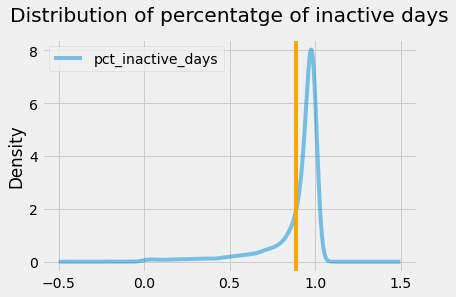

In [ ]:
# distribution 
mean = data['pct_inactive_days'].mean()
data['pct_inactive_days'].plot.kde(alpha = 0.5, label = 'pct_inactive_days', legend = True)
plt.axvline(mean, c='orange',label='mean')
plt.title('Distribution of percentatge of inactive days', y = 1.05)

# regular activity
mask = data['pct_inactive_days'] <= data['pct_inactive_days'].mean()
regular_activity = data[mask]
regulars = df['merchant'].isin(regular_activity['merchant']) # dated table filtered by regular activity merchants
regulars = df[regulars]

# ocasional - seasonal activity
# for ocasional activity we expect a low transactions_buyday ratio and a constant avg_spend_month
# for seasonal activity we expect a high transactions_buyday ratio and a non-constant avg_spend_month
seasonal_activity = data[~mask]
seasonals = df['merchant'].isin(seasonal_activity['merchant']) # dated table filtered by regular activity merchants
seasonals = df[seasonals]

df['yearmonth'] = df['yearmonth'].astype('str')

For the Great merchants we expect to see now a clear uptrend without peaks, remember that we doubled the number of customer on 2034 so we expect an increasing number of transactions, and a very different trend for ocassional merchants.

Text(0, 0.5, 'transactions')

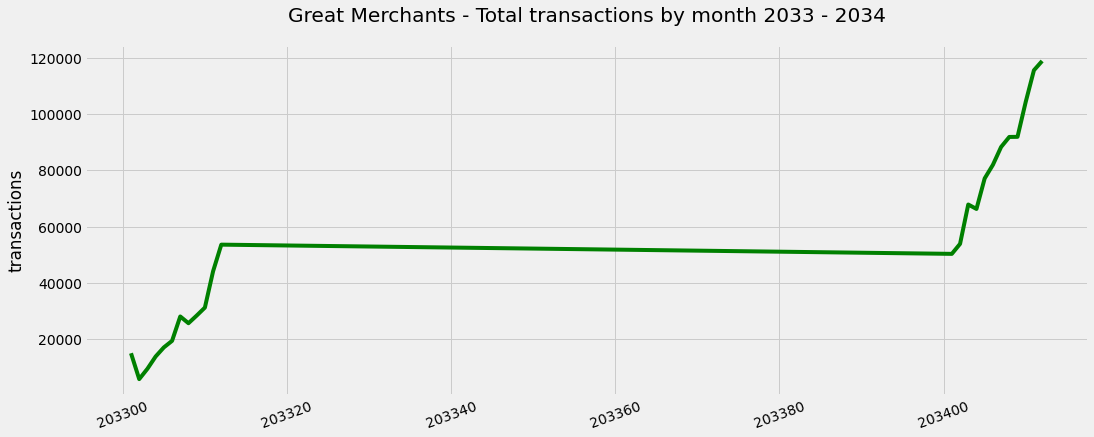

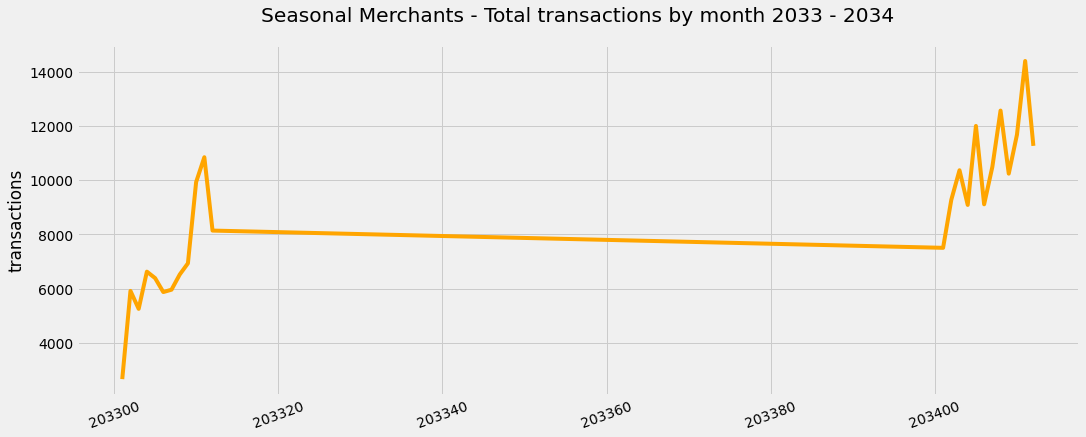

In [ ]:
# total transactions by month
plt.figure(figsize=(16,6))

dataset = regulars.groupby(['yearmonth'])['date'].count().reset_index() # regulars
dataset.columns = ['yearmonth','transactions']
plt.plot('yearmonth', 'transactions', data=dataset, color='green')
# dataset = seasonals.groupby(['yearmonth'])['date'].count().reset_index() # seasonal
# dataset.columns = ['yearmonth','transactions']
# plt.plot('yearmonth', 'transactions', data=dataset, color='orange')

plt.title('Great Merchants - Total transactions by month 2033 - 2034', y = 1.05)
plt.xticks(rotation=20)
plt.ylabel('transactions')

# total transactions by month
plt.figure(figsize=(16,6))

# dataset = regulars.groupby(['yearmonth'])['date'].count().reset_index() # regulars
# dataset.columns = ['yearmonth','transactions']
# plt.plot('yearmonth', 'transactions', data=dataset, color='green')
dataset = seasonals.groupby(['yearmonth'])['date'].count().reset_index() # seasonal
dataset.columns = ['yearmonth','transactions']
plt.plot('yearmonth', 'transactions', data=dataset, color='orange')

plt.title('Seasonal Merchants - Total transactions by month 2033 - 2034', y = 1.05)
plt.xticks(rotation=20)
plt.ylabel('transactions')

Great! We got two very diferent trend lines as we expected, the green line shows a constant increasement of the number of transactions whilst the orange line presents several peaks from september 2033 onwards that represent a high number of transactions on specific moments over the year, what we consider a seasonal or ocasional behavior. We can conclude then that effectively there are two different behaviours represented on these charts.

Now, we will take only the list of seasonal/ocasional merchants in order to separate these two groups. On the one hand, we will have seasonal customers, those who did many transactions in few days and on the other hand we will have ocasional customers, those who did just one or two transactions on several days over the year, what we consider an ocasional activity.

In order to do so, we will use the ratio between total transactions and the number of days the merchant did a transaction that we create earlier, a ratio of 1 would mean that the merchand did each transaction in different days, what we will consider an 'Ocasional' behaviour, whilst a bigger ratio would imply some kind of high volume of transactions on few days, what we will consider a 'Seasonal' behaviour. We will set our threeshold at ratio = 1.2 to include as well customers with less than 3 transactions in the same date.

Text(0, 0.5, 'transactions')

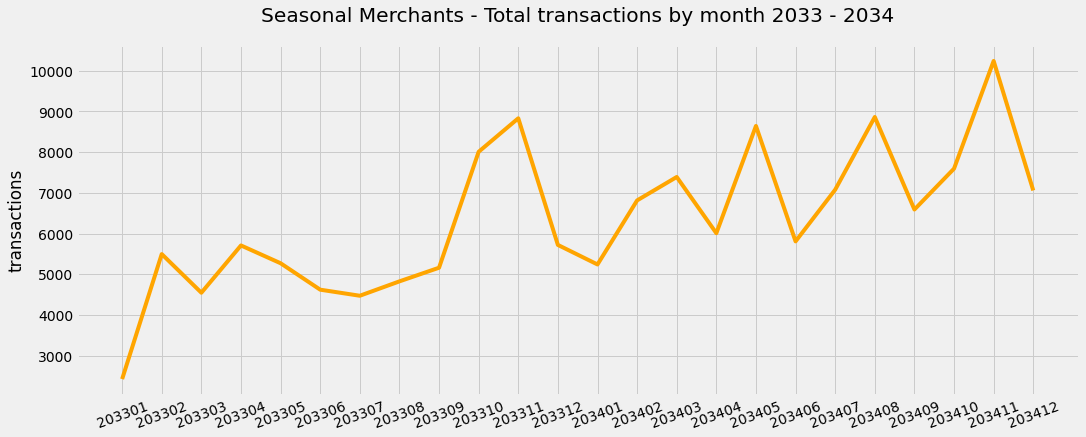

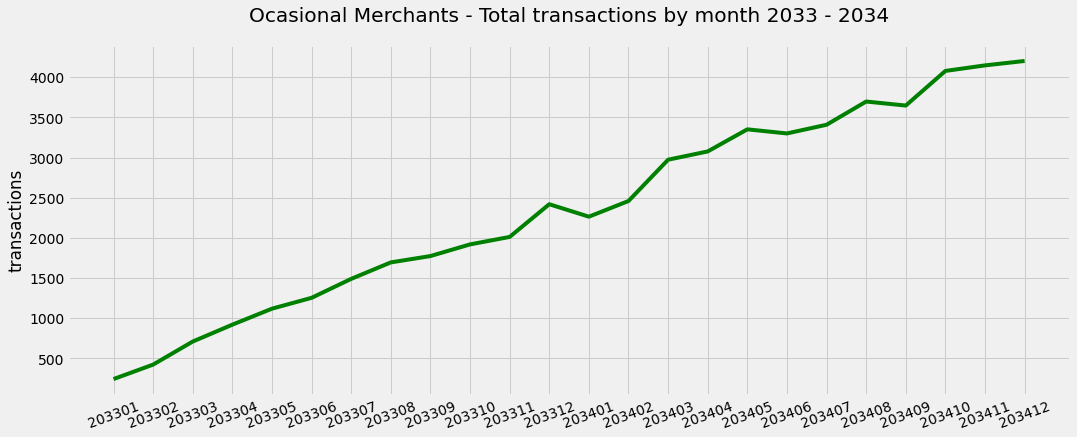

In [ ]:
# seasonal activity
mask = seasonal_activity['transactions_buyday'] >= 1.2
high_tr_day = seasonal_activity[mask]
high_tr_day = df['merchant'].isin(high_tr_day['merchant']) # dated table filtered by seasonal merchants
high_tr_day = df[high_tr_day]

# total transactions by month
plt.figure(figsize=(16,6))
dataset = high_tr_day.groupby(['yearmonth'])['date'].count().reset_index() # transactions
dataset.columns = ['yearmonth','transactions']
plt.plot('yearmonth', 'transactions', data=dataset, color='orange')

plt.title('Seasonal Merchants - Total transactions by month 2033 - 2034', y = 1.05)
plt.xticks(rotation=20)
plt.ylabel('transactions')

# ocasional activity
ocasional = seasonal_activity[~mask]
ocasional = df['merchant'].isin(ocasional['merchant']) # dated table filtered by ocasional merchants
ocasional = df[ocasional]

# total transactions by month
plt.figure(figsize=(16,6))
dataset = ocasional.groupby(['yearmonth'])['date'].count().reset_index() # seasonal
dataset.columns = ['yearmonth','transactions']
plt.plot('yearmonth', 'transactions', data=dataset, color='green')

plt.title('Ocasional Merchants - Total transactions by month 2033 - 2034', y = 1.05)
plt.xticks(rotation=20)
plt.ylabel('transactions')

Excellent, as we already seen before, we have again two completely different behaviors, meaning that we have been able to separate our dataset into seasonal and ocasional merchants.

Now let's see how our list of merchants is distributed applying our new classification:

Text(0.5, 0, '% of merchants')

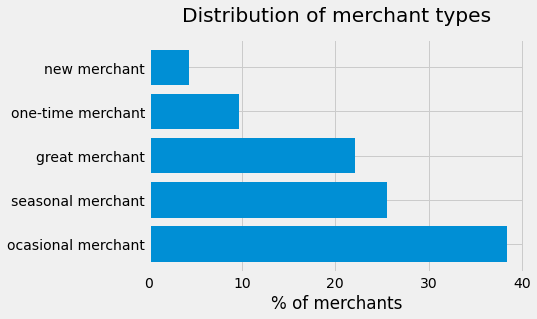

In [ ]:
merchant_type = {}

# get lists of merchants by type
new_merchants_list = new_merchants['merchant'].to_list()
one_time_list = one_time['merchant'].to_list()
regulars_list = regulars['merchant'].to_list()
high_tr_day_list = high_tr_day['merchant'].to_list()
ocasional_list = ocasional['merchant'].to_list()

# assign tags based on merchant type
for mer in merchant['merchant'].to_list():
  if mer in new_merchants_list:
    merchant_type[mer] = 'new merchant'
  elif mer in one_time_list:
    merchant_type[mer] = 'one-time merchant'
  elif mer in regulars_list:
    merchant_type[mer] = 'great merchant'
  elif mer in high_tr_day_list:
    merchant_type[mer] = 'seasonal merchant'
  elif mer in ocasional_list:
    merchant_type[mer] = 'ocasional merchant'
  else:
    merchant_type[mer] = 'not defined'

# Add merchant_type to table of merchants
merchant['merchant_type'] = merchant['merchant'].map(merchant_type)

# frequency table
merchant_type_dist = merchant['merchant_type'].value_counts( normalize = True).reset_index()
merchant_type_dist.columns = ['merchant_type','pct_merchants']
merchant_type_dist['pct_merchants'] = merchant_type_dist['pct_merchants']*100

# bar chart
plt.barh(merchant_type_dist['merchant_type'],merchant_type_dist['pct_merchants'])
plt.title('Distribution of merchant types', y = 1.05)
plt.xlabel('% of merchants')

From looking at the chart above see how ocasional merchants represent roughtly 38%, followed by seasonal mechants and great merchants with 25 and 22% respectively.

At this point, we are ready to identify merchants with no spend in the last 90 days, which is our definition of churn for this dataset. Let's tag them and plot again the barchart only with merchants who churned to see if we keep the same distribution:

Text(0.5, 0, '% of merchants')

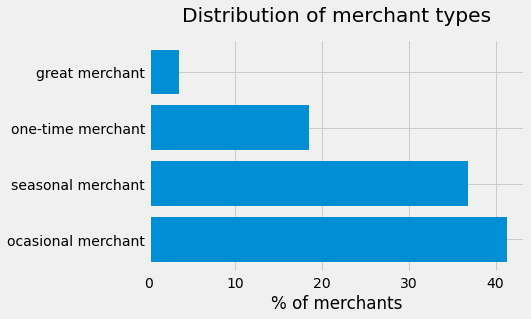

In [ ]:
merchant['churn'] = merchant['cons_inactive_days'].apply(lambda x: 1 if x >= 90 else 0)

# dataset only with churn
mask = merchant['churn'] == 1
churn = merchant[mask]

# frequency table
churn = churn['merchant_type'].value_counts( normalize = True).reset_index()
churn.columns = ['merchant_type','pct_merchants']
churn['pct_merchants'] = churn['pct_merchants']*100

# bar chart
plt.barh(churn['merchant_type'],churn['pct_merchants'])
plt.title('Distribution of merchant types', y = 1.05)
plt.xlabel('% of merchants')

Based on chart above, we should focus our efforts on developing techniques that could prevent churn specially on seasonal and ocasional merchants. For instance, we should run initiatives that make ocasional merchants increase their activity with us, increase the engadgement with our products/platform and tried to convert them on great merchants. Otherwise for seasonal merchants, we should prepare powerful campaigns before each peak to ensure this type of merchants repeat with us season after season.

In [ ]:
# Export table Merchant
filename = '/content/drive/My Drive/python/merchant.csv'
merchant.to_csv(filename,index=False)

# Create a ML model to predict churn

In [ ]:
# Read from file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

filename = '/content/drive/My Drive/python/merchant.csv'
merchant = pd.read_csv(filename,index_col=False) 
# merchant = merchant.iloc[:,1:]

merchant.head()

,merchant,first_buy_date,last_buy_date,tenure_days,cons_inactive_days,total_transactions,active_days,inactive_days,pct_inactive_days,transactions_buyday,avg_transactions_month,total_spend,avg_spend_month,avg_spend_trans_month,merchant_type,churn
0,0002b63b92,2033-05-16,2033-05-16,595,594,1,1,594,0.998319,1.0,1.000000,33.79,33.790000,33.790000,one-time merchant,1
1,0002d07bba,2034-10-11,2034-12-15,82,16,4,4,78,0.951220,1.0,1.333333,892.78,297.593333,225.295000,ocasional merchant,0
2,00057d4302,2033-05-30,2033-08-04,581,514,28,2,579,0.996558,14.0,14.000000,295.21,147.605000,10.148155,seasonal merchant,1
3,000bcff341,2033-08-09,2033-08-09,510,509,1,1,509,0.998039,1.0,1.000000,78.26,78.260000,78.260000,one-time merchant,1
4,000ddbf0ca,2033-06-02,2033-06-02,578,577,1,1,577,0.998270,1.0,1.000000,102.99,102.990000,102.990000,one-time merchant,1


In [ ]:
# check correlation between columns
print(merchant.corr()["churn"].abs().sort_values(ascending=False))

churn                     1.000000
cons_inactive_days        0.785051
pct_inactive_days         0.394144
inactive_days             0.388211
tenure_days               0.278960
active_days               0.274813
total_spend               0.147683
total_transactions        0.124010
avg_transactions_month    0.049350
avg_spend_month           0.039182
transactions_buyday       0.034348
avg_spend_trans_month     0.002160
Name: churn, dtype: float64


The table above clearly show us that columns cons_inactive_days, pct_inactive_days and inactive_days are highly correlated to the target which could lead us to obtain, by mistake, higher accuracy scores.

cons_inactive_days is the key feature we used before to determine churn, so effectively this feature is highly correlated to the target.

For the other two features, we will choose just 1, pct_inactive_days due to is more representative for the merchant's behaviour.

## feature engineering

In [ ]:
# Train, test
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Set predictors and remove useless columns
predictors = merchant.drop(["churn","merchant","first_buy_date","last_buy_date","cons_inactive_days","inactive_days"],axis=1)
target = merchant["churn"]

In [ ]:
# Encode categorical columns generating binary values using get_dummies
predictors = pd.get_dummies(predictors, columns=["merchant_type"], prefix=["Type_is"] )

predictors['Type_is_great merchant'] = np.int8(predictors['Type_is_great merchant'])
predictors['Type_is_new merchant'] = np.int8(predictors['Type_is_new merchant'])
predictors['Type_is_ocasional merchant'] = np.int8(predictors['Type_is_ocasional merchant'])
predictors['Type_is_one-time merchant'] = np.int8(predictors['Type_is_one-time merchant'])
predictors['Type_is_seasonal merchant'] = np.int8(predictors['Type_is_seasonal merchant'])

predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14351 entries, 0 to 14350
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tenure_days                 14351 non-null  int64  
 1   total_transactions          14351 non-null  int64  
 2   active_days                 14351 non-null  int64  
 3   pct_inactive_days           14351 non-null  float64
 4   transactions_buyday         14351 non-null  float64
 5   avg_transactions_month      14351 non-null  float64
 6   total_spend                 14351 non-null  float64
 7   avg_spend_month             14351 non-null  float64
 8   avg_spend_trans_month       14351 non-null  float64
 9   Type_is_great merchant      14351 non-null  int8   
 10  Type_is_new merchant        14351 non-null  int8   
 11  Type_is_ocasional merchant  14351 non-null  int8   
 12  Type_is_one-time merchant   14351 non-null  int8   
 13  Type_is_seasonal merchant   143

In [ ]:
# Scale numeric values
from sklearn import preprocessing

predictors_2 = predictors
min_max_scaler = preprocessing.MinMaxScaler()
predictors_2 = min_max_scaler.fit_transform(predictors_2)
predictors_2 = pd.DataFrame(predictors_2)

predictors_2.columns = predictors.columns
predictors_2.head()

,tenure_days,total_transactions,active_days,pct_inactive_days,transactions_buyday,avg_transactions_month,total_spend,avg_spend_month,avg_spend_trans_month,Type_is_great merchant,Type_is_new merchant,Type_is_ocasional merchant,Type_is_one-time merchant,Type_is_seasonal merchant
0,0.814815,0.000000,0.000000,0.999691,0.000000,0.000000,0.000013,0.000040,0.000356,0.0,0.0,0.0,1.0,0.0
1,0.111111,0.000118,0.004149,0.952526,0.000000,0.000099,0.000376,0.000374,0.002503,0.0,0.0,1.0,0.0,0.0
2,0.795610,0.001058,0.001383,0.997927,0.007747,0.003873,0.000124,0.000184,0.000091,0.0,0.0,0.0,0.0,1.0
3,0.698217,0.000000,0.000000,0.999410,0.000000,0.000000,0.000032,0.000097,0.000855,0.0,0.0,0.0,1.0,0.0
4,0.791495,0.000000,0.000000,0.999641,0.000000,0.000000,0.000043,0.000128,0.001132,0.0,0.0,0.0,1.0,0.0


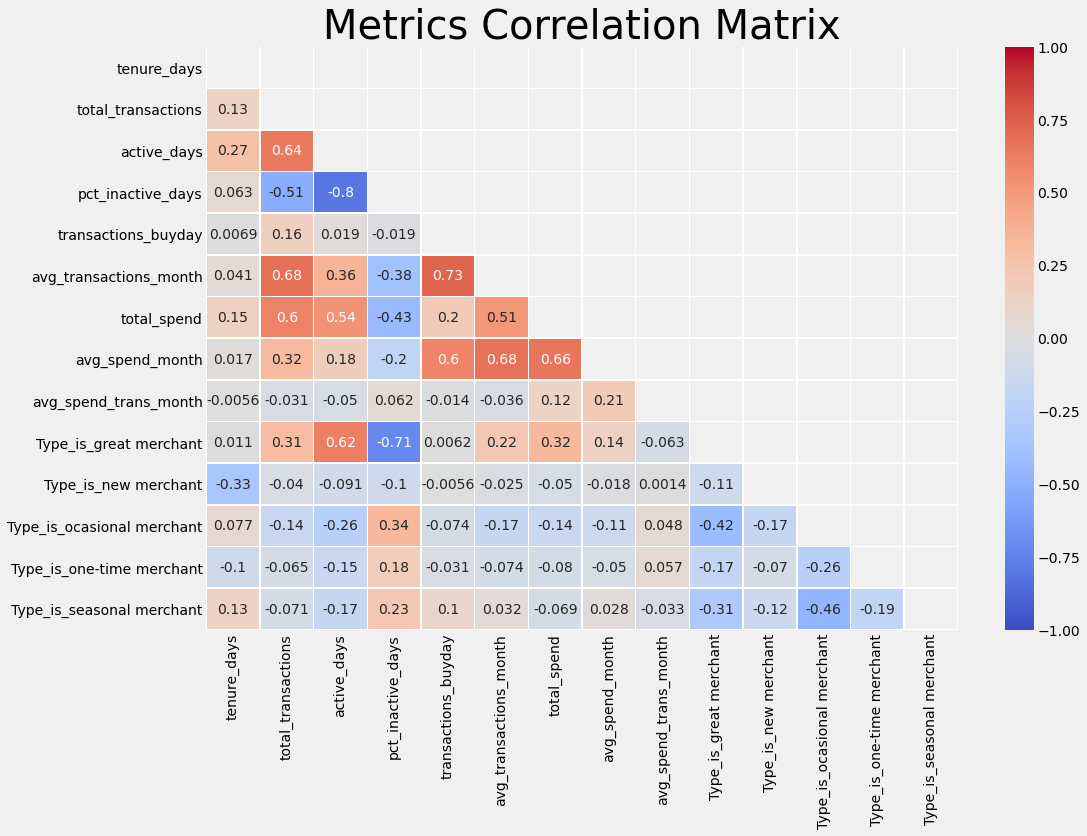

In [ ]:
import matplotlib.pyplot as plt

mask = np.zeros_like(predictors_2.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

plt.figure(figsize=(15,10))
plt.title("Metrics Correlation Matrix", fontsize=40)
x = sns.heatmap(
    predictors_2.corr(), 
    cmap='coolwarm',
    annot=True,
    mask=mask,
    linewidths = .5,
    vmin = -1, 
    vmax = 1,
)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)

In [ ]:
X_train.shape

(11480, 14)

In [ ]:
X_test.shape

(2871, 14)

In [ ]:
Y_train.shape

(11480,)

In [ ]:
Y_test.shape

(2871,)

Now that we have checked that the size of the samples are the ones we expected, let's try different models for our classification model:
- Logistic Regression
- Naive Bayes
- SVM
- K Nearest Neighbors
- Decision Tree
- Random Forest
- XGBoost
- Neural Network


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=34, solver='lbfgs', multi_class="auto", n_jobs=-1, C=1)
lr.fit(X_train,Y_train)
accuracy_score = lr.score(X_test, Y_test)
accuracy_score = round(accuracy_score*100,2)
print("The accuracy score achieved using Logistic Regression is: "+str(accuracy_score)+" %")

The accuracy score achieved using Logistic Regression is: 78.02 %


In [ ]:
predictions = lr.predict(X_test)
predictions[:10]

array([0, 0, 1, 1, 0, 1, 1, 0, 0, 1])

In [ ]:
from sklearn.metrics import confusion_matrix

# https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62

confusion_matrix(Y_test, predictions)

array([[1202,  465],
       [ 166, 1038]])

In [ ]:
import pickle

# save the model to disk
filename = '/content/drive/My Drive/python/DS project/logistic_regression.sav'
pickle.dump(lr, open(filename, 'wb'))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

0.7802159526297457


##Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train,Y_train)
accuracy_score = nb.score(X_test, Y_test)
accuracy_score = round(accuracy_score*100,2)
print("The accuracy score achieved using Naive Bayes is: "+str(accuracy_score)+" %")

The accuracy score achieved using Naive Bayes is: 54.72 %


In [ ]:
predictions = nb.predict(X_test)
predictions[:10]

array([1, 0, 1, 1, 0, 1, 1, 1, 0, 1])

In [ ]:
confusion_matrix(Y_test, predictions)

array([[ 424, 1243],
       [  57, 1147]])

##SVM

In [ ]:
from sklearn import svm

sv = svm.SVC(kernel='linear')
sv.fit(X_train, Y_train)
accuracy_score = sv.score(X_test, Y_test)
accuracy_score = round(accuracy_score*100,2)
print("The accuracy score achieved using Support Vector Machine is: "+str(accuracy_score)+" %")

In [ ]:
predictions = nb.predict(X_test)
predictions[:10]

In [ ]:
confusion_matrix(Y_test, predictions)

##K Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,Y_train)
accuracy_score = knn.score(X_test, Y_test)
accuracy_score = round(accuracy_score*100,2)
print("The accuracy score achieved using KNN is: "+str(accuracy_score)+" %")

In [ ]:
predictions = knn.predict(X_test)
predictions[:10]

In [ ]:
confusion_matrix(Y_test, predictions)

## Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

max_accuracy = 0

for x in range(200):
    dt = DecisionTreeClassifier(random_state=x)
    dt.fit(X_train,Y_train)
    Y_pred_dt = dt.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_dt,Y_test)*100,2)
    if(current_accuracy > max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        
#print(max_accuracy)
#print(best_x)

dt = DecisionTreeClassifier(random_state=best_x)
dt.fit(X_train,Y_train)
accuracy_score = dt.score(X_test, Y_test)
accuracy_score = round(accuracy_score*100,2)
print("The accuracy score achieved using Decision Tree is: "+str(accuracy_score)+" %")

The accuracy score achieved using Decision Tree is: 84.05 %


In [ ]:
predictions = dt.predict(X_test)
predictions[:10]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1])

In [ ]:
confusion_matrix(Y_test, predictions)

array([[1471,  196],
       [ 262,  942]])

In [ ]:
import pickle

# save the model to disk
filename = '/content/drive/My Drive/python/DS project/decision_tree.sav'
pickle.dump(dt, open(filename, 'wb'))

##Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

max_accuracy = 0


for x in range(2000):
    rf = RandomForestClassifier(random_state=x)
    rf.fit(X_train,Y_train)
    Y_pred_rf = rf.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_rf,Y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        
#print(max_accuracy)
#print(best_x)

rf = RandomForestClassifier(random_state=best_x)
rf.fit(X_train,Y_train)
accuracy_score = dt.score(X_test, Y_test)
accuracy_score = round(accuracy_score*100,2)
print("The accuracy score achieved using Random Forest is: "+str(accuracy_score)+" %")

In [ ]:
predictions = rf.predict(X_test)
predictions[:10]

In [ ]:
confusion_matrix(Y_test, predictions)

In [ ]:
import pickle

# save the model to disk
filename = '/content/drive/My Drive/python/DS project/random_forest.sav'
pickle.dump(rf, open(filename, 'wb'))

##XGBoost


In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, Y_train)
accuracy_score = xgb_model.score(X_test, Y_test)
accuracy_score = round(accuracy_score*100,2)
print("The accuracy score achieved using XGBoost is: "+str(accuracy_score)+" %")

The accuracy score achieved using XGBoost is: 87.11 %


In [ ]:
predictions = xgb_model.predict(X_test)
predictions[:10]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1])

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(Y_test, predictions)

array([[1517,  150],
       [ 220,  984]])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1667
           1       0.87      0.82      0.84      1204

    accuracy                           0.87      2871
   macro avg       0.87      0.86      0.87      2871
weighted avg       0.87      0.87      0.87      2871



In [ ]:
import pickle

# save the model to disk
filename = '/content/drive/My Drive/python/DS project/xgboost.sav'
pickle.dump(xgb_model, open(filename, 'wb'))

## Classification model with Keras

In [ ]:
# tutorial: https://www.pluralsight.com/guides/classification-keras

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 

In [ ]:
# one hot encode outputs: Convert a class vector (integers) to binary class matrix.

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

count_classes = Y_test.shape[1]
print(count_classes)

2


### Model 1

In [ ]:
model = Sequential()
model.add(Dense(500, activation='relu', input_dim=14))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# build the model
# history = model.fit(X_train, Y_train, epochs=20)
history = model.fit(X_train, Y_train, epochs=100, batch_size=len(X_train), verbose=2)

Epoch 1/100
1/1 - 0s - loss: 49.0828 - accuracy: 0.6884
Epoch 2/100
1/1 - 0s - loss: 37.7230 - accuracy: 0.6433
Epoch 3/100
1/1 - 0s - loss: 67.0730 - accuracy: 0.4724
Epoch 4/100
1/1 - 0s - loss: 44.1532 - accuracy: 0.5672
Epoch 5/100
1/1 - 0s - loss: 37.0236 - accuracy: 0.6385
Epoch 6/100
1/1 - 0s - loss: 39.1611 - accuracy: 0.6698
Epoch 7/100
1/1 - 0s - loss: 41.3735 - accuracy: 0.6823
Epoch 8/100
1/1 - 0s - loss: 42.1754 - accuracy: 0.6893
Epoch 9/100
1/1 - 0s - loss: 40.7436 - accuracy: 0.6875
Epoch 10/100
1/1 - 0s - loss: 35.7211 - accuracy: 0.6716
Epoch 11/100
1/1 - 0s - loss: 27.8588 - accuracy: 0.6633
Epoch 12/100
1/1 - 0s - loss: 19.4283 - accuracy: 0.6465
Epoch 13/100
1/1 - 0s - loss: 12.3439 - accuracy: 0.5765
Epoch 14/100
1/1 - 0s - loss: 26.8095 - accuracy: 0.4353
Epoch 15/100
1/1 - 0s - loss: 14.5959 - accuracy: 0.6658
Epoch 16/100
1/1 - 0s - loss: 26.3687 - accuracy: 0.6871
Epoch 17/100
1/1 - 0s - loss: 28.9202 - accuracy: 0.6863
Epoch 18/100
1/1 - 0s - loss: 21.9229 - 

In [ ]:
pred_train= model.predict(X_train)
scores = model.evaluate(X_train, Y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(round((scores[1]*100),2), 1 - scores[1]))   
 
pred_test= model.predict(X_test)
scores2 = model.evaluate(X_test, Y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(round((scores2[1]*100),2), 1 - scores2[1]))    

Accuracy on training data: 71.07% 
 Error on training data: 0.28928571939468384
Accuracy on test data: 71.65% 
 Error on test data: 0.28352493047714233


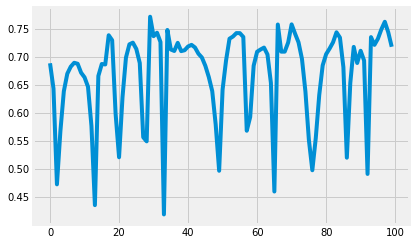

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['accuracy'])
pyplot.show()

### Model 2: Reduce nodes to half and change loss to binary crossentropy

In [ ]:
model = Sequential()
model.add(Dense(250, activation='relu', input_dim=14))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# build the model
# history = model.fit(X_train, Y_train, epochs=20)
history = model.fit(X_train, Y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
230/230 - 0s - loss: 2.9783 - accuracy: 0.7316
Epoch 2/100
230/230 - 0s - loss: 2.7092 - accuracy: 0.7430
Epoch 3/100
230/230 - 0s - loss: 2.3551 - accuracy: 0.7111
Epoch 4/100
230/230 - 0s - loss: 1.8832 - accuracy: 0.7483
Epoch 5/100
230/230 - 0s - loss: 1.1789 - accuracy: 0.7678
Epoch 6/100
230/230 - 0s - loss: 0.4416 - accuracy: 0.8174
Epoch 7/100
230/230 - 0s - loss: 0.4079 - accuracy: 0.8302
Epoch 8/100
230/230 - 0s - loss: 0.3988 - accuracy: 0.8330
Epoch 9/100
230/230 - 0s - loss: 0.4253 - accuracy: 0.8355
Epoch 10/100
230/230 - 0s - loss: 0.4936 - accuracy: 0.8164
Epoch 11/100
230/230 - 0s - loss: 0.3867 - accuracy: 0.8391
Epoch 12/100
230/230 - 0s - loss: 0.4371 - accuracy: 0.8197
Epoch 13/100
230/230 - 0s - loss: 0.3886 - accuracy: 0.8415
Epoch 14/100
230/230 - 0s - loss: 0.3792 - accuracy: 0.8476
Epoch 15/100
230/230 - 0s - loss: 0.3963 - accuracy: 0.8353
Epoch 16/100
230/230 - 0s - loss: 0.3987 - accuracy: 0.8366
Epoch 17/100
230/230 - 0s - loss: 0.3963 - accura

In [ ]:
pred_train= model.predict(X_train)
scores = model.evaluate(X_train, Y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(round((scores[1]*100),2), 1 - scores[1]))   
 
pred_test= model.predict(X_test)
scores2 = model.evaluate(X_test, Y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(round((scores2[1]*100),2), 1 - scores2[1]))    

Accuracy on training data: 86.63% 
 Error on training data: 0.1337108016014099
Accuracy on test data: 86.66% 
 Error on test data: 0.1334030032157898


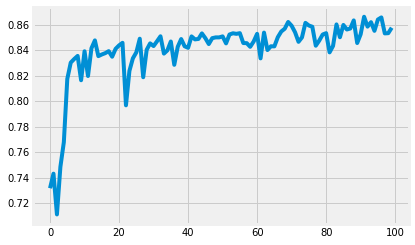

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.show()

## Machine Learning Thresholds
https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415


In [ ]:
predictions = lr.predict_proba(X_test)[:,1]
predictions

array([0.48202084, 0.28962428, 0.59360482, ..., 0.64127849, 0.5240647 ,
       0.4856041 ])

<Figure size 1152x432 with 0 Axes>

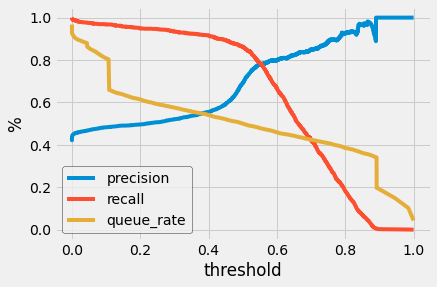

<Figure size 1152x432 with 0 Axes>

In [ ]:
from sklearn.metrics import precision_recall_curve 

precision, recall, thresholds = precision_recall_curve(Y_test, predictions) 
thresholds = np.append(thresholds, 1) 
queue_rate = [] 

for threshold in thresholds: 
    queue_rate.append((pred_test >= threshold).mean()) 
plt.plot(thresholds, precision, color=sns.color_palette()[0]) 
plt.plot(thresholds, recall, color=sns.color_palette()[1]) 
plt.plot(thresholds, queue_rate, color=sns.color_palette()[2]) 
leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True) 
leg.get_frame().set_edgecolor('k') 
plt.xlabel('threshold') 
plt.ylabel('%')

plt.figure(figsize=(16,6))


Text(0, 0.5, '%')

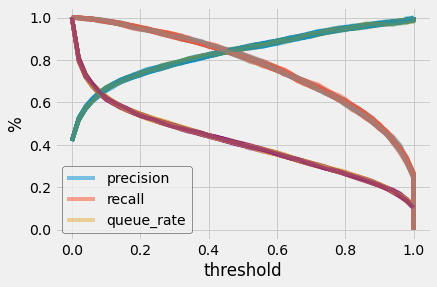

In [ ]:
# 50 trials:

clf = RandomForestClassifier(n_estimators=50, oob_score=True) 
n_trials = 50 
plot_data = [] 

for trial in range(n_trials): 
    X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)    
    clf.fit(X_train, Y_train) 
    predictions = clf.predict_proba(X_test)[:,1] 
    precision, recall, thresholds = precision_recall_curve(Y_test, predictions) 
    thresholds = np.append(thresholds, 1) 

    queue_rate = [] 
    for threshold in thresholds: 
        queue_rate.append((predictions >= threshold).mean()) 

    plot_data.append({ 
        'thresholds': thresholds 
      , 'precision': precision 
      , 'recall': recall 
      , 'queue_rate': queue_rate 
    }) 

for p in plot_data: 
    plt.plot(p['thresholds'], p['precision'], color=sns.color_palette()[0], alpha=0.5) 
    plt.plot(p['thresholds'], p['recall'], color=sns.color_palette()[1], alpha=0.5) 
    plt.plot(p['thresholds'], p['queue_rate'], color=sns.color_palette()[2], alpha=0.5) 

leg = plt.legend(('precision', 'recall', 'queue_rate'),frameon=True) 
leg.get_frame().set_edgecolor('k') 
plt.xlabel('threshold') 
plt.ylabel('%')

Text(0, 0.5, '%')

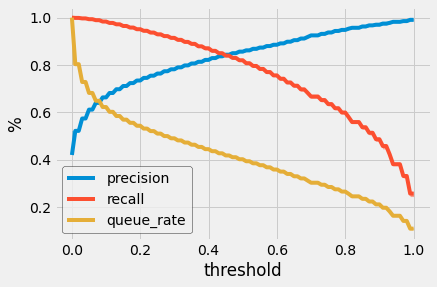

In [ ]:
# We can make more precise statements with a statistical visualization. 
# Let’s plot the median curves, along with a 90% central interval for each threshold:

import bisect 
from scipy.stats import mstats 

uniform_thresholds = np.linspace(0, 1, 101) 
uniform_precision_plots = [] 
uniform_recall_plots= [] 
uniform_queue_rate_plots= []

for p in plot_data: 
    uniform_precision = [] 
    uniform_recall = [] 
    uniform_queue_rate = [] 
    for ut in uniform_thresholds: 
        index = bisect.bisect_left(p['thresholds'], ut) 
        uniform_precision.append(p['precision'][index]) 
        uniform_recall.append(p['recall'][index]) 
        uniform_queue_rate.append(p['queue_rate'][index]) 
    uniform_precision_plots.append(uniform_precision)   
    uniform_recall_plots.append(uniform_recall) 
    uniform_queue_rate_plots.append(uniform_queue_rate) 

quantiles = [0.1, 0.5, 0.9] 

lower_precision, median_precision, upper_precision = mstats.mquantiles(uniform_precision_plots, quantiles, axis=0) 
lower_recall, median_recall, upper_recall = mstats.mquantiles(uniform_recall_plots, quantiles, axis=0) 
lower_queue_rate, median_queue_rate, upper_queue_rate = mstats.mquantiles(uniform_queue_rate_plots, quantiles, axis=0) 

plt.plot(uniform_thresholds, median_precision) 
plt.plot(uniform_thresholds, median_recall) 
plt.plot(uniform_thresholds, median_queue_rate) 

plt.fill_between(uniform_thresholds, upper_precision, lower_precision, alpha=0.5, linewidth=0, color=sns.color_palette()[0]) 
plt.fill_between(uniform_thresholds, upper_recall, lower_recall, alpha=0.5, linewidth=0, color=sns.color_palette()[1]) 
plt.fill_between(uniform_thresholds, upper_queue_rate, lower_queue_rate, alpha=0.5, linewidth=0, color=sns.color_palette()[2]) 

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True) 
leg.get_frame().set_edgecolor('k') 
plt.xlabel('threshold') 
plt.ylabel('%')

Text(0.5, 1.0, 'Payout as a Function of Threshold')

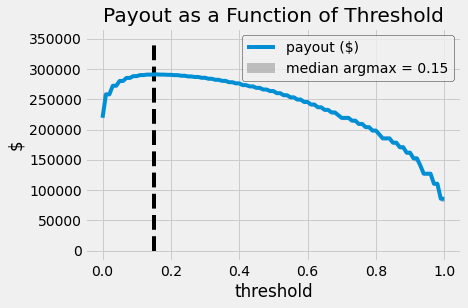

In [ ]:
# Max return
uniform_thresholds = np.linspace(0, 1, 101)
 
uniform_payout_plots = [] 
n = 10000 
success_payoff = 100 
case_cost = 20

for p in plot_data: 
    uniform_payout = [] 
    for ut in uniform_thresholds: 
        index = bisect.bisect_left(p['thresholds'], ut) 
        precision = p['precision'][index] 
        queue_rate = p['queue_rate'][index] 
        
        payout = n*queue_rate*(precision*100 - case_cost)     
        uniform_payout.append(payout) 
    uniform_payout_plots.append(uniform_payout) 

quantiles = [0.1, 0.5, 0.9] 
lower_payout, median_payout, upper_payout = mstats.mquantiles(uniform_payout_plots, quantiles, axis=0) 
plt.plot(uniform_thresholds, median_payout) 
plt.fill_between(uniform_thresholds, upper_payout, lower_payout, alpha=0.5, linewidth=0, color=sns.color_palette()[4]) 
max_ap = uniform_thresholds[np.argmax(median_payout)] 
plt.vlines([max_ap], 0, 350000, linestyles='--') 
leg = plt.legend(('payout ($)', 'median argmax = {:.2f}'.format(max_ap)), frameon=True) 
leg.get_frame().set_edgecolor('k') 
plt.xlabel('threshold') 
plt.ylabel('$') 
plt.title("Payout as a Function of Threshold")

In [ ]:
print(np.max(median_payout))

290909.09090909094
